<a href="https://colab.research.google.com/github/DarekGit/Documents/blob/master/05_03_01_WIDERFACE_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Porównanie modeli

In [1]:
import os

os.makedirs('WIDER/', exist_ok=True)

# Download WIDER FACE VAL
!gdown https://drive.google.com/uc?id=1-5A_pa_jDS7gk8mHVCBB7ApV5KN8jWDr -O WIDER/tempv.zip
!unzip -q WIDER/tempv.zip -d WIDER
!rm WIDER/tempv.zip  

# Download WIDER FACE test
!gdown https://drive.google.com/uc?id=1tTpUJZEQMKDVxKT6100V5FwDuGX_8sDi -O WIDER/tempt.zip
!unzip -q WIDER/tempt.zip -d WIDER
!rm WIDER/tempt.zip

# Download face annotations (wider_face_split.zip)
!wget mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip -O WIDER/wider_face_split.zip
!unzip -q WIDER/wider_face_split.zip -d WIDER
!rm WIDER/wider_face_split.zip

### WIDER FACE - Examples and formats of the submissions
!wget mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/example/Submission_example.zip -O WIDER/Submission_example.zip
!unzip -q WIDER/Submission_example.zip -d WIDER
!rm WIDER/Submission_example.zip

# eval_tools

!wget shuoyang1213.me/WIDERFACE/support/eval_script/eval_tools.zip
!unzip eval_tools.zip

# Download tools

!gdown https://drive.google.com/uc?id=1_9ydMZlTNFXBOMl16xsU8FSBmK2PW4lN -O WIDER/tools.py
!wget -q -O WIDER/mAP.py https://drive.google.com/uc?id=1PtEsobTFah3eiCDbSsYblOGbe2fmkjGR

# mobilenet
!gdown https://drive.google.com/uc?id=1U0SVkSaSio4TBiXvF1QfTZI65WYpXpZ9
!unzip -qo mobilenet.zip
!rm -f mobilenet.zip

# install detectron2:

!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -q -e detectron2_repo

Downloading...
From: https://drive.google.com/uc?id=1-5A_pa_jDS7gk8mHVCBB7ApV5KN8jWDr
To: /content/WIDER/tempv.zip
363MB [00:02, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tTpUJZEQMKDVxKT6100V5FwDuGX_8sDi
To: /content/WIDER/tempt.zip
1.84GB [00:14, 125MB/s]
--2020-07-30 09:45:50--  http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/bbx_annotation/wider_face_split.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)... 137.189.99.12
Connecting to mmlab.ie.cuhk.edu.hk (mmlab.ie.cuhk.edu.hk)|137.189.99.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3591642 (3.4M) [application/zip]
Saving to: ‘WIDER/wider_face_split.zip’

WIDER/wider_face_sp 100%[===================>]   3.42M  2.44MB/s    in 1.4s    

2020-07-30 09:45:52 (2.44 MB/s) - ‘WIDER/wider_face_split.zip’ saved [3591642/3591642]

--2020-07-30 09:45:55--  http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/example/Submission_example.zip
Resolving mmlab.ie.cuhk.edu.hk (mmlab

Restart runtime to continue... 

In [ ]:
!nvidia-smi
from psutil import virtual_memory
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(virtual_memory().total / 1e9))

Wed Jul 29 16:31:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import time
from tqdm.notebook import tqdm
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


import gdown
from google.colab import drive
import os
import cv2
import random
import itertools
import shutil
import glob
import json
import numpy as np
import pandas as pd
from PIL import ImageDraw, Image
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import collections as mc

from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
import detectron2.utils.comm as comm
from detectron2.engine import DefaultPredictor, DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.structures import BoxMode
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

from mobilenet.utils import  add_mobilenet_config, build_mobilenetv2_fpn_backbone
from WIDER.mAP import mAP, plot_mAP
from WIDER.tools import annotations,output_Files

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Modele do testu 

In [ ]:
models = {
    # '800k' - parametry domyślne - jako punkt odniesienia
    '800k': {
        'config': 'FrozenBN',
        'pth': 'https://drive.google.com/uc?id=1-tqNKwZIFmkAbfJ1L2sibIO4PT_MwnVA',
        'weights_name': 'model_0799999.pth'},

    # 'BN_800k' - dodano BN - pokazanie wpływu BN przy małym batchu=2
    'BN_800k': {
        'config': 'BN',
        'pth': 'https://drive.google.com/uc?id=1-kRDjqkMk9qXbNfzVx09VE35YzgkP1AO',
        'weights_name': 'model_0799999.pth'},

    #'BN_Mish_V2_250+F_2_50k' - najlepszy wynik uczenie z Mish BN 250k + 50k z FrozenBN
    'BN_Mish_V2_250+F_2_50k': {
        'config': 'BN_Mish_V2F',
        'pth': 'https://drive.google.com/uc?id=1-I6YSAs9NrORI4cFISfK_-4Yhm1twfDi',
        'weights_name': 'model_0049999.pth'},
    
    # 'BN_Mish_V3_80+30k' - najszybsze uczenie 110k iteracji
    'BN_Mish_V3_80+_30k': {
        'config': 'BN_Mish_V3',
        'pth': 'https://drive.google.com/uc?id=1--bP5VPyqIrfrBxVZ5eLSsupIvBlQ8ef',
        'weights_name': 'model_0029999.pth'},

    # 'R50_C4_270k' - Detectron2 z backbone na R50 C4
    'R50_C4_270k': {
        'config': 'R50_C4',
        'pth': 'https://drive.google.com/uc?id=1-I4m091opkwIRHhvMLftt0eAQp6G0CmJ',
        'weights_name': 'model_0269999.pth'}
    }

Zestawy z konfiguracja podstawowych (cfg)

In [ ]:
cfg_set = {
    'FrozenBN':'https://drive.google.com/uc?id=1rZFzJaR_g7uYuTguTdbUuCQYD4eXLeqw',
    'BN': 'https://drive.google.com/uc?id=1-doXtwe5iZHoqPzKGc2ZZbxj6Ebhxsn4',
    'BN_V2':'https://drive.google.com/uc?id=1wywB8UAaOO5KZx3IS35kV-rLsvJMIse6',
    'BN_Mish':'https://drive.google.com/uc?id=1-axV3KKg8-YiZZ7uDBh_2v181JoC9Nj3',
    'BN_Mish_V2':'https://drive.google.com/uc?id=1WoESx5RYvpapNicpSrmMoNJeE2GVm3zK',
    'BN_Mish_V3':'https://drive.google.com/uc?id=1-Kgd_2AS4EsD_ZPqP7SxkscyDjP-Qhnr',
    'BN_Mish_V2F':'https://drive.google.com/uc?id=1pCwyYCjIoduro2vIKMZi5HhlpaypH0_x',
    'R50_C4':'https://drive.google.com/uc?id=1-5P5Xyx5GM26p7g89CY-SSX0aluB7H9U',}

In [ ]:
def cfg_write(cfg,cfg_all):
  for key in cfg_all.keys():
    if isinstance(cfg_all[key],dict): 
      cfg_write(cfg[key],cfg_all[key])
    else: cfg[key]=cfg_all[key]
  return cfg

def set_predictor(model_name=None, models_dict=models, cfg_dict=cfg_set ,device='cuda', cfg_DATASETS_TEST=None):
  url = models_dict[model_name]['pth'] 
  out = models_dict[model_name]['weights_name']
  gdown.download(url, out, True)
  # model configuration
  url_cfg = cfg_dict[models_dict[model_name]['config']] 
  gdown.download(url_cfg, "temporary.json", True)
  with open('temporary.json','r') as f:
    cfg_all=json.load(f)
  cfg = get_cfg()
  add_mobilenet_config(cfg)
  cfg = cfg_write(cfg,cfg_all)
  cfg.MODEL.WEIGHTS = models_dict[model_name]['weights_name']
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
  cfg.MODEL.DEVICE=device
  if cfg_DATASETS_TEST is not None:
    cfg.DATASETS.TEST = (cfg_DATASETS_TEST, )

  return DefaultPredictor(cfg), cfg

Funkcja pomiaru czasu ewaluacji modelu

In [ ]:
def time_measurement(predictor, dataset):
  time_ = []
  for item in tqdm(dataset):
    start_ = time.time()
    img = cv2.imread(item["file_name"])
    outputs = predictor(img)
    diff = time.time() - start_
    time_.append(diff)
  # Total time
  total_time = np.array(time_).sum()
  # Mean time
  mean_diff = np.array(time_).mean()
  # Frames per second 
  fps = 1 / mean_diff
  print("Total time(sec): {:.2f}, Average(sec):{:.2f}, fps:{:.2f}\n".format(total_time, mean_diff, fps))
  return {"total_time": total_time, "mean_diff": mean_diff, "fps": fps}

Funkcja do ewaluacji modelu na zbiorze walidacyjnym WIDER FACE

In [ ]:
def predict_on_val(dataset, predictor, model_name):
    gbxs=[]
    dbxs=[]
    dset=dataset
    if 'annotations' in dataset[0].keys():  
      dset=[]
      for r in dataset:
        dset.append({'path' : r['file_name'],'marks' : [b['bbox'] for b in r['annotations']],
                     'persons': ['' for b in r['annotations']]})

    for item in tqdm(dset):
        im = cv2.imread(item["path"])
        outputs = predictor(im)
        pbxs = outputs['instances'].pred_boxes.tensor.tolist()
        pconfs = outputs['instances'].scores.tolist()
        dbx=[[*(np.array(bx)+0.5).astype('int'),pconfs[i]] for i,bx in enumerate(pbxs)]
        dbxs.append(dbx)
        gbxs.append(item['marks'])
    
    return {'gbxs':gbxs,'dbxs':dbxs,'metric':dset} 

Funkcje do ewaluacji modelu na zbiorze testowym WIDER FACE i umożliwiające zapis wyników do pliku

In [ ]:
def read_wider_face_test_filelist(path='WIDER/wider_face_split/'):
  full_path = path+"wider_face_test_filelist.txt"
  if os.path.exists(full_path):
    test_files = []
    with open(full_path, 'r') as f:
      for row in f:
        test_files.append(row.split('\n')[0])
    return test_files

In [ ]:
def predict_on_test(file_list, predictor, model_name, path="WIDER/WIDER_test/images/"):
  output_list = []
  for item in tqdm(file_list):
    if os.path.exists(path+item):
      record = {}
      img = cv2.imread(path+item)
      outputs = predictor(img)
      pbxs = outputs['instances'].pred_boxes.tensor.tolist()
      pconfs = outputs['instances'].scores.tolist()
      dbx=[[*(np.array(bx)+0.5).astype('int'),pconfs[i]] for i,bx in enumerate(pbxs)]
      record['file_name'] = item
      record['faces'] = len(dbx)
      record["bbox"] = dbx
    output_list.append(record)
  return output_list

In [ ]:
def save_predictions_to_files(preds, model_name, wider_path = 'WIDER/WIDER_test/'):
  """The function saves the results as shown in the example 
  mmlab.ie.cuhk.edu.hk/projects/WIDERFace/support/example/Submission_example.zip
  """
  if not os.path.isdir(wider_path+model_name): # 
    os.makedirs(wider_path+model_name)
  for item in tqdm(preds):
    subdirectory = os.path.split(item["file_name"])[0]
    if not os.path.isdir(wider_path+model_name+"/"+subdirectory):
      os.makedirs(wider_path+model_name+"/"+subdirectory)
    output_file = os.path.split(item["file_name"])[1][:-4]
    output_file = wider_path+model_name+"/"+subdirectory+"/"+output_file
    with open(output_file + '.txt', 'w') as f:
      f.write(output_file + os.linesep)
      f.write(str(item["faces"]) + os.linesep)
      for row in item['bbox']:
        row[-1] = round(row[-1],3)
        f.write(" ".join([str(i) for i in row]) + os.linesep)

In [ ]:
def dict_to_file(dic, path):
    f = open(path,'w')
    f.write(str(dic))
    f.close()

def dict_from_file(filename):
    f = open(filename,'r')
    data=f.read()
    f.close()
    return eval(data)

In [ ]:
# save_predictions_to_files(preds, model_name)

In [ ]:
# WIDERFACE_VAL = annotations('val')
# WIDERFACE_test=read_wider_face_test_filelist()

Pomiar czasu ewaluacji modeli na zbiorze walidacyjnym

In [ ]:
WIDERFACE_VAL = annotations('val')

In [ ]:
time_measurement_results = {}
for model in models:
  print(model)
  predictor, _ = set_predictor(model)
  time_measurement_results[model] = time_measurement(predictor, dataset=WIDERFACE_VAL)

print(time_measurement_results)

800k



Total time(sec): 242.49, Average(sec):0.08, fps:13.30

BN_800k



Total time(sec): 240.91, Average(sec):0.07, fps:13.39

BN_Mish_V2_250+F_2_50k



Total time(sec): 313.10, Average(sec):0.10, fps:10.30

BN_Mish_V3_80+_30k



Total time(sec): 314.58, Average(sec):0.10, fps:10.26

R50_C4_270k
WARNING [07/29 08:34:33 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.



Total time(sec): 877.45, Average(sec):0.27, fps:3.68

{'800k': {'total_time': 242.489501953125, 'mean_diff': 0.07516723557133446, 'fps': 13.303668711495847}, 'BN_800k': {'total_time': 240.90951204299927, 'mean_diff': 0.07467746808524466, 'fps': 13.390919987518801}, 'BN_Mish_V2_250+F_2_50k': {'total_time': 313.1049087047577, 'mean_diff': 0.09705669829657709, 'fps': 10.303255906607191}, 'BN_Mish_V3_80+_30k': {'total_time': 314.5769786834717, 'mean_diff': 0.09751301261111955, 'fps': 10.255041591094976}, 'R50_C4_270k': {'total_time': 877.453289270401, 'mean_diff': 0.271994200021823, 'fps': 3.676548984940733}}


In [ ]:
time_measurement_results

{'800k': {'fps': 13.303668711495847,
  'mean_diff': 0.07516723557133446,
  'total_time': 242.489501953125},
 'BN_800k': {'fps': 13.390919987518801,
  'mean_diff': 0.07467746808524466,
  'total_time': 240.90951204299927},
 'BN_Mish_V2_250+F_2_50k': {'fps': 10.303255906607191,
  'mean_diff': 0.09705669829657709,
  'total_time': 313.1049087047577},
 'BN_Mish_V3_80+_30k': {'fps': 10.255041591094976,
  'mean_diff': 0.09751301261111955,
  'total_time': 314.5769786834717},
 'R50_C4_270k': {'fps': 3.676548984940733,
  'mean_diff': 0.271994200021823,
  'total_time': 877.453289270401}}

Porównanie wyników 

In [ ]:
df_time_measurement_results = pd.DataFrame.from_dict(time_measurement_results, orient='index')
df_time_measurement_results

,total_time,mean_diff,fps
800k,242.4895,0.0752,13.3037
BN_800k,240.9095,0.0747,13.3909
BN_Mish_V2_250+F_2_50k,313.1049,0.0971,10.3033
BN_Mish_V3_80+_30k,314.5770,0.0975,10.2550
R50_C4_270k,877.4533,0.2720,3.6765


Ewaluacja modeli na zbiorze walidacyjnym i mAP liczone funkcją Darka

In [ ]:
WIDERFACE_VAL = annotations('val')

In [ ]:
pred = {}
for model in models:
  print(model)
  predictor, cfg = set_predictor(model)
  pred[model] = predict_on_val(WIDERFACE_VAL,predictor,model)

800k



BN_800k



BN_Mish_V2_250+F_2_50k



BN_Mish_V3_80+_30k



R50_C4_270k
WARNING [07/29 10:00:29 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


In [ ]:
drive.mount('/content/drive')
OUTPUT_DIR_NAME = "OUTPUT_DIR_VAL"
OUTPUT_DIR_PATH = os.path.join("./drive/My Drive", OUTPUT_DIR_NAME)

if not os.path.exists(OUTPUT_DIR_PATH):
  os.makedirs(OUTPUT_DIR_PATH)

print(OUTPUT_DIR_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
./drive/My Drive/OUTPUT_DIR_VAL


In [ ]:
output_file_name = "VAL_output_dict"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(pred, output_file)

In [ ]:
!ls -la /content/drive/'My Drive'/OUTPUT_DIR_VAL/VAL_output_dict

-rw------- 1 root root 16922017 Jul 29 10:50 '/content/drive/My Drive/OUTPUT_DIR_VAL/VAL_output_dict'


In [ ]:
output_file_name = "time_measurement_results_dict"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(time_measurement_results, output_file)

In [ ]:
!ls -la /content/drive/'My Drive'/OUTPUT_DIR_VAL/time_measurement_results_dict

-rw------- 1 root root 558 Jul 29 10:54 '/content/drive/My Drive/OUTPUT_DIR_VAL/time_measurement_results_dict'


In [ ]:
dict_from_file(output_file)

{'800k': {'fps': 13.303668711495847,
  'mean_diff': 0.07516723557133446,
  'total_time': 242.489501953125},
 'BN_800k': {'fps': 13.390919987518801,
  'mean_diff': 0.07467746808524466,
  'total_time': 240.90951204299927},
 'BN_Mish_V2_250+F_2_50k': {'fps': 10.303255906607191,
  'mean_diff': 0.09705669829657709,
  'total_time': 313.1049087047577},
 'BN_Mish_V3_80+_30k': {'fps': 10.255041591094976,
  'mean_diff': 0.09751301261111955,
  'total_time': 314.5769786834717},
 'R50_C4_270k': {'fps': 3.676548984940733,
  'mean_diff': 0.271994200021823,
  'total_time': 877.453289270401}}

mAP dla testowanych modeli 

In [ ]:
def model_mAP(pdict, model_name, title="Detectron2_Wider_Face_mAP_"):
  m,d=mAP(gbxs=pdict[model_name]['gbxs'],dbxs=pdict[model_name]['dbxs'],data=True)
  # plot_mAP(m,d,['All 0.50','All 0.00','large','medium','small'],1,title+model_name+'  conf>0',file=title+model_name)
  plot_mAP(m,d,'All',1,title+model_name+'  conf>0',file=title+model_name)
  return m,d

In [ ]:
all_models_mAP = {}
pred.keys()

dict_keys(['800k', 'BN_800k', 'BN_Mish_V2_250+F_2_50k', 'BN_Mish_V3_80+_30k', 'R50_C4_270k'])

Model: 800k
All 0.50:   AP: 43.35%   Recall: 45.21%   IoU: 0.50
All 0.55:   AP: 41.80%   Recall: 43.76%   IoU: 0.55
All 0.60:   AP: 39.40%   Recall: 41.53%   IoU: 0.60
All 0.65:   AP: 36.16%   Recall: 38.58%   IoU: 0.65
All 0.70:   AP: 31.27%   Recall: 34.34%   IoU: 0.70
All 0.75:   AP: 24.04%   Recall: 28.24%   IoU: 0.75
All 0.80:   AP: 14.93%   Recall: 20.53%   IoU: 0.80
All 0.85:   AP:  6.28%   Recall: 12.27%   IoU: 0.85
All 0.90:   AP:  1.01%   Recall:  4.54%   IoU: 0.90
All 0.95:   AP:  0.02%   Recall:  0.67%   IoU: 0.95
All 0.00:   AP: 47.88%   Recall: 49.82%   IoU: 0.00
small   :   AP: 31.04%   Recall: 33.19%   IoU: 0.50
medium  :   AP: 74.95%   Recall: 76.37%   IoU: 0.50
large   :   AP: 68.67%   Recall: 70.94%   IoU: 0.50


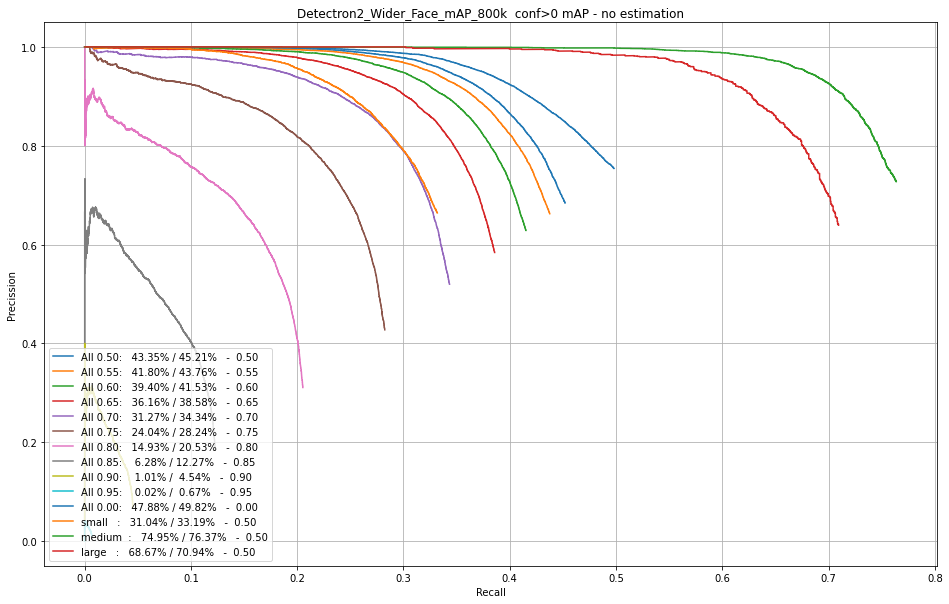

In [ ]:
modelshow = list(pred.keys())[0]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="Detectron2_Wider_Face_mAP_")

Model: BN_800k
All 0.50:   AP: 50.31%   Recall: 51.33%   IoU: 0.50
All 0.55:   AP: 48.69%   Recall: 49.87%   IoU: 0.55
All 0.60:   AP: 45.97%   Recall: 47.47%   IoU: 0.60
All 0.65:   AP: 42.32%   Recall: 44.33%   IoU: 0.65
All 0.70:   AP: 37.20%   Recall: 39.90%   IoU: 0.70
All 0.75:   AP: 29.82%   Recall: 33.68%   IoU: 0.75
All 0.80:   AP: 19.89%   Recall: 25.47%   IoU: 0.80
All 0.85:   AP:  9.00%   Recall: 15.64%   IoU: 0.85
All 0.90:   AP:  1.62%   Recall:  6.08%   IoU: 0.90
All 0.95:   AP:  0.03%   Recall:  0.87%   IoU: 0.95
All 0.00:   AP: 53.77%   Recall: 54.57%   IoU: 0.00
small   :   AP: 36.10%   Recall: 37.50%   IoU: 0.50
medium  :   AP: 83.83%   Recall: 84.47%   IoU: 0.50
large   :   AP: 90.83%   Recall: 91.30%   IoU: 0.50


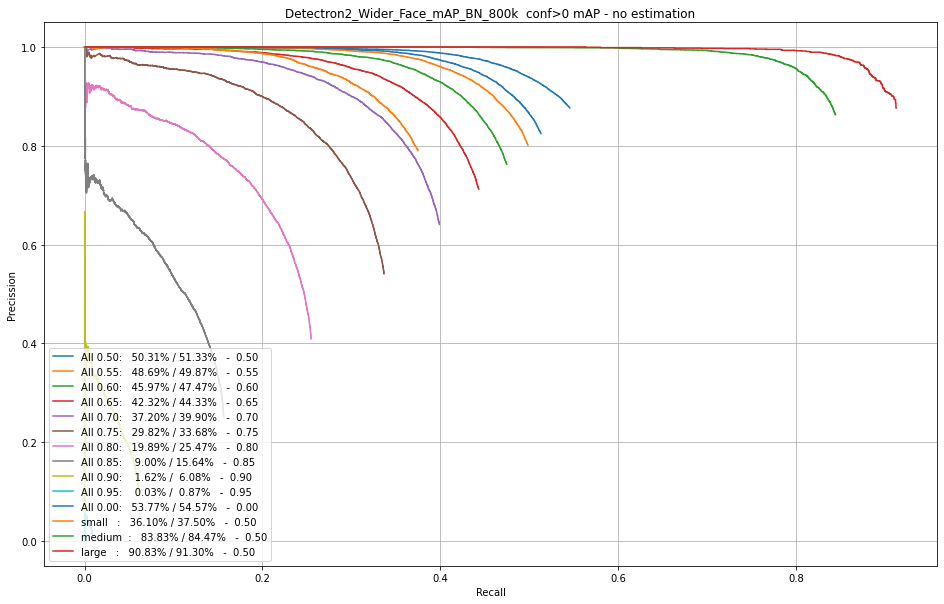

In [ ]:
modelshow = list(pred.keys())[1]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="Detectron2_Wider_Face_mAP_")

Model: BN_Mish_V2_250+F_2_50k
All 0.50:   AP: 55.34%   Recall: 56.37%   IoU: 0.50
All 0.55:   AP: 53.69%   Recall: 54.89%   IoU: 0.55
All 0.60:   AP: 50.77%   Recall: 52.28%   IoU: 0.60
All 0.65:   AP: 46.79%   Recall: 48.81%   IoU: 0.65
All 0.70:   AP: 41.04%   Recall: 43.84%   IoU: 0.70
All 0.75:   AP: 32.45%   Recall: 36.85%   IoU: 0.75
All 0.80:   AP: 21.34%   Recall: 27.71%   IoU: 0.80
All 0.85:   AP:  9.15%   Recall: 16.71%   IoU: 0.85
All 0.90:   AP:  1.52%   Recall:  6.40%   IoU: 0.90
All 0.95:   AP:  0.03%   Recall:  0.94%   IoU: 0.95
All 0.00:   AP: 58.49%   Recall: 59.33%   IoU: 0.00
small   :   AP: 41.59%   Recall: 43.11%   IoU: 0.50
medium  :   AP: 87.79%   Recall: 88.30%   IoU: 0.50
large   :   AP: 93.72%   Recall: 93.98%   IoU: 0.50


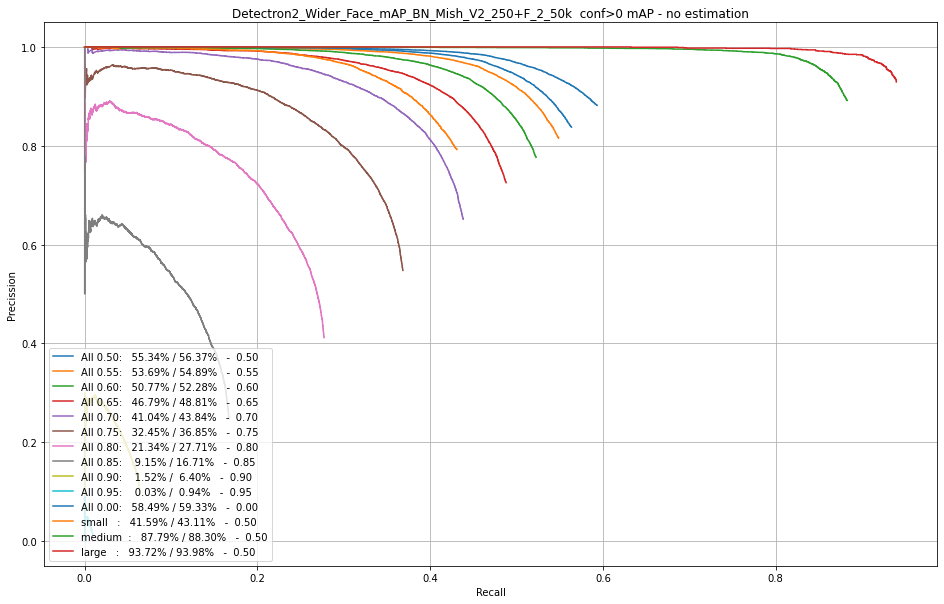

In [ ]:
modelshow = list(pred.keys())[2]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="Detectron2_Wider_Face_mAP_")

Model: BN_Mish_V3_80+_30k
All 0.50:   AP: 52.61%   Recall: 53.39%   IoU: 0.50
All 0.55:   AP: 51.03%   Recall: 51.98%   IoU: 0.55
All 0.60:   AP: 48.78%   Recall: 50.01%   IoU: 0.60
All 0.65:   AP: 45.21%   Recall: 46.99%   IoU: 0.65
All 0.70:   AP: 39.62%   Recall: 42.37%   IoU: 0.70
All 0.75:   AP: 31.45%   Recall: 35.82%   IoU: 0.75
All 0.80:   AP: 20.52%   Recall: 27.06%   IoU: 0.80
All 0.85:   AP:  8.73%   Recall: 16.45%   IoU: 0.85
All 0.90:   AP:  1.50%   Recall:  6.36%   IoU: 0.90
All 0.95:   AP:  0.04%   Recall:  0.98%   IoU: 0.95
All 0.00:   AP: 55.35%   Recall: 55.94%   IoU: 0.00
small   :   AP: 38.57%   Recall: 39.71%   IoU: 0.50
medium  :   AP: 85.83%   Recall: 86.27%   IoU: 0.50
large   :   AP: 92.25%   Recall: 92.53%   IoU: 0.50


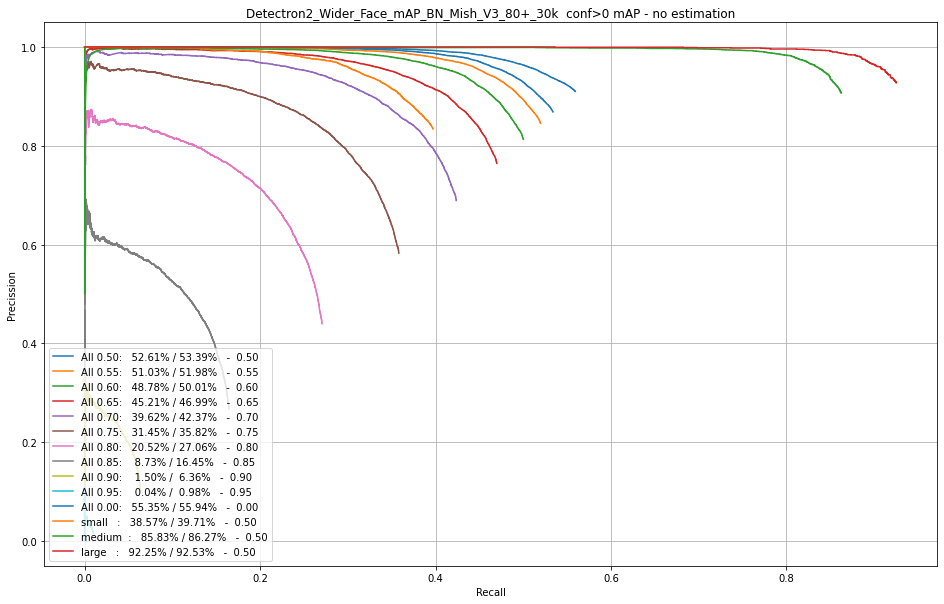

In [ ]:
modelshow = list(pred.keys())[3]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="Detectron2_Wider_Face_mAP_")

Model: R50_C4_270k
All 0.50:   AP: 58.47%   Recall: 60.24%   IoU: 0.50
All 0.55:   AP: 55.87%   Recall: 57.80%   IoU: 0.55
All 0.60:   AP: 52.27%   Recall: 54.50%   IoU: 0.60
All 0.65:   AP: 47.51%   Recall: 50.19%   IoU: 0.65
All 0.70:   AP: 40.98%   Recall: 44.41%   IoU: 0.70
All 0.75:   AP: 33.00%   Recall: 37.28%   IoU: 0.75
All 0.80:   AP: 22.48%   Recall: 28.17%   IoU: 0.80
All 0.85:   AP: 10.83%   Recall: 17.55%   IoU: 0.85
All 0.90:   AP:  2.46%   Recall:  7.31%   IoU: 0.90
All 0.95:   AP:  0.08%   Recall:  1.23%   IoU: 0.95
All 0.00:   AP: 64.59%   Recall: 66.30%   IoU: 0.00
small   :   AP: 44.08%   Recall: 47.20%   IoU: 0.50
medium  :   AP: 91.60%   Recall: 92.03%   IoU: 0.50
large   :   AP: 95.68%   Recall: 95.84%   IoU: 0.50


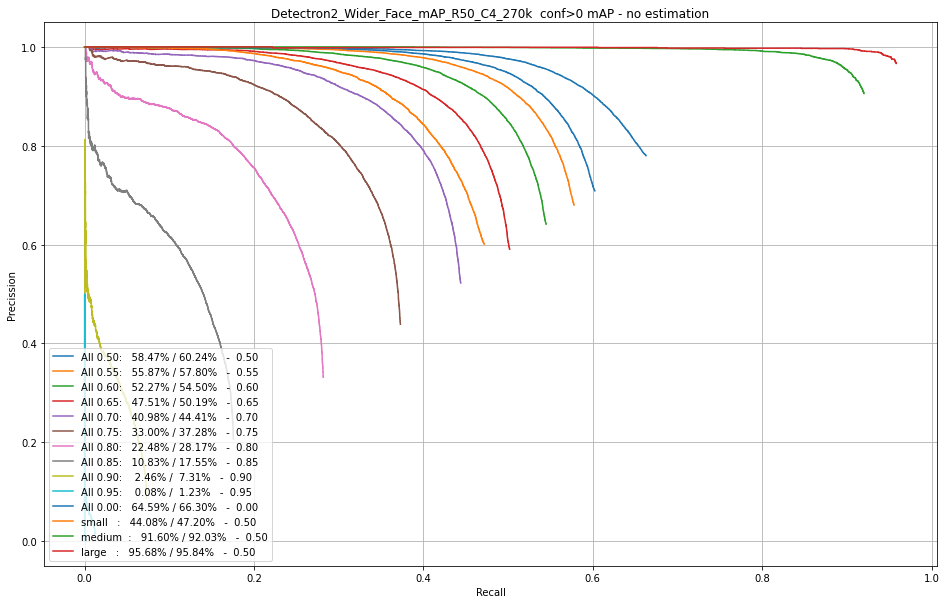

In [ ]:
modelshow = list(pred.keys())[4]
print("Model:", modelshow)
all_models_mAP[modelshow] = model_mAP(pred, modelshow, title="Detectron2_Wider_Face_mAP_")

Zapis wyników 

In [ ]:
output_file_name = "all_models_mAP"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(all_models_mAP, output_file)

In [ ]:
DD_mAP = {}
for item in all_models_mAP.keys():
  for i in all_models_mAP[item][0].keys():
    modeldict[i] =  {
        "AP" : all_models_mAP[item][0][i][0]*100,
        "Recall" : all_models_mAP[item][0][i][1]*100,
        "IoU" : all_models_mAP[item][0][i][2]*100,
    }
  DD_mAP[item] = modeldict 

In [ ]:
output_file_name = "all_models_mAP_t"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(DD_mAP, output_file)

Ewaluacja na zbiorze walidayjnym z wykorzystaniem COCOEvaluator i funkcji 

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [ ]:
val = annotations('val')
test = annotations('test')

In [ ]:
for d in ["test", "val"]:
  DatasetCatalog.register("face_" + d, lambda d=d: test if d == "test" else val)
  MetadataCatalog.get("face_" + d).set(thing_classes = ['face'])

faces_metadata = MetadataCatalog.get("face_test")

In [ ]:
AP_VAL = {}
drive.mount('/content/drive')
OUTPUT_DIR_NAME = "OUTPUT_DIR_VAL"
OUTPUT_DIR_PATH = os.path.join("./drive/My Drive", OUTPUT_DIR_NAME)

if not os.path.exists(OUTPUT_DIR_PATH):
  os.makedirs(OUTPUT_DIR_PATH)

for model in models:
  print(model)
  destination = os.path.join(OUTPUT_DIR_PATH, model)
  if not os.path.exists(destination):
    os.makedirs(destination)
  predictor, cfg = set_predictor(model, cfg_DATASETS_TEST="face_val")
  print(cfg.DATASETS.TEST)
  print(destination)

  evaluator = COCOEvaluator(cfg.DATASETS.TEST[0], cfg, True, output_dir=destination)
  val_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
  inference_on_dataset(predictor.model, val_loader, evaluator)
  AP_VAL[model] = evaluator.evaluate()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
800k
('face_val',)
./drive/My Drive/OUTPUT_DIR_VAL/800k
[07/29 11:37:18 d2.evaluation.coco_evaluation]: 'face_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[07/29 11:37:18 d2.data.datasets.coco]: Converting annotations of dataset 'face_val' to COCO format ...)
[07/29 11:37:18 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[07/29 11:37:24 d2.data.datasets.coco]: Conversion finished, #images: 3226, #annotations: 39708
[07/29 11:37:24 d2.data.datasets.coco]: Caching COCO format annotations at './drive/My Drive/OUTPUT_DIR_VAL/800k/face_val_coco_format.json' ...
[07/29 11:37:25 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    face    | 39708        |
|            |              |
[07/29 11:37:25 d2.data.commo

In [ ]:
output_file_name = "AP_VAL_COCOEvaluator"
output_file = os.path.join(OUTPUT_DIR_PATH, output_file_name)
dict_to_file(AP_VAL, output_file)

Porównanie wyników

In [ ]:
AP_VAL2 = {}
for item in AP_VAL.keys():
  AP_VAL2[item] = AP_VAL[item]['bbox']

df_AP_VAL = pd.DataFrame.from_dict(AP_VAL2, orient='index')

In [ ]:
df_time_measurement_results

,total_time,mean_diff,fps
800k,242.4895,0.0752,13.3037
BN_800k,240.9095,0.0747,13.3909
BN_Mish_V2_250+F_2_50k,313.1049,0.0971,10.3033
BN_Mish_V3_80+_30k,314.5770,0.0975,10.2550
R50_C4_270k,877.4533,0.2720,3.6765


Wybór modelu do testu na zbiorze testowym

In [ ]:
selected_models = []

Ewaluacja modelu na zbiorze testowym 

In [ ]:
AP_TEST = {}
drive.mount('/content/drive')
OUTPUT_DIR_NAME = "OUTPUT_DIR_TEST" #TEST
OUTPUT_DIR_PATH = os.path.join("./drive/My Drive", OUTPUT_DIR_NAME)

if not os.path.exists(OUTPUT_DIR_PATH):
  os.makedirs(OUTPUT_DIR_PATH)

for model in selected_models:
  print(model)
  destination = os.path.join(OUTPUT_DIR_PATH, model)
  if not os.path.exists(destination):
    os.makedirs(destination)
  predictor, cfg = set_predictor(model, cfg_DATASETS_TEST="face_test") # test
  print(cfg.DATASETS.TEST) 
  print(destination)

  evaluator = COCOEvaluator(cfg.DATASETS.TEST[0], cfg, True, output_dir=destination)
  val_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
  inference_on_dataset(predictor.model, val_loader, evaluator))
  AP_TEST[model] = evaluator.evaluate()

Wyniki